In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from tqdm.autonotebook import tqdm
import time
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
"""
Our Grid Object
"""
class Grid:
    def __init__(self,width,height,start):
        self.width = width
        self.height = height
        self.i = start[0] #vertical axis
        self.j = start[1] #horizontal axis
    
    def set(self,actions,rewards,obey_prob):
        self.actions = actions # dict:  (row,col): list of actions
        self.rewards = rewards # dict:  (row,col):  reward
        self.obey_prob = obey_prob
    
    def non_terminal_states(self):
        return self.actions.keys()
    
    def set_state(self,s):
        #change current stae
        self.i = s[0]
        self.j = s[1]
    
    def current_state(self):
        return (self.i,self.j)
    
    def is_terminal(self,s):
        return s not in self.actions
    
    def stochastic_move(self, action):
        p = np.random.random()
        if p <= self.obey_prob:
            return action
        if action == 'U' or action == 'D':
            return np.random.choice(['L', 'R'])
        elif action == 'L' or action == 'R':
            return np.random.choice(['U', 'D'])
    
    def move(self,action):
        actual_action = self.stochastic_move(action)
        if actual_action in self.actions[(self.i, self.j)]:
            if actual_action == 'U':
                self.i -= 1
            elif actual_action == 'D':
                self.i += 1
            elif actual_action == 'R':
                self.j += 1
            elif actual_action == 'L':
                self.j -= 1
        return self.rewards.get((self.i, self.j), 0)
    
    def check_move(self,action):
        i = self.i
        j = self.j
        #check move validity
        if action in self.actions[(i,j)]:
            if action == "U":
                i-=1
            elif action == "D":
                i+=1
            elif action == "R":
                j+=1
            elif action == "L":
                j-=1
                
        reward = self.rewards.get((i,j),0)
        return ((i,j),reward)
    
    def get_transition_probs(self,action):
        # returns a list of (probability, reward, s') transition tuples
        probs = []
        state, reward = self.check_move(action)
        probs.append((self.obey_prob,reward,state))
        
        """
        if obey prob is 0.8
        and if action is 'up' then 
        'up' has probabiltiy of 0.8
        'left' has probability of 0.1
        'right' has probability of 0.1
        """
        disobey_prob = 1-self.obey_prob
        if disobey_prob <= 0:
            return probs
        if action == "U" or action == "D":
            state, reward = self.check_move("L")
            probs.append((disobey_prob/2,reward,state))
            state, reward = self.check_move("R")
            probs.append((disobey_prob/2,reward,state))
        elif action == "L" or action == "R":
            state, reward = self.check_move("U")
            probs.append((disobey_prob/2,reward,state))
            state,reward = self.check_move("D")
            probs.append((disobey_prob/2,reward,state))
        return probs
    
    def game_over(self):
        #return True if game is over else False
        #true if we are in state where no action are possible
        return (self.i,self.j) not in self.actions.keys()
    
    def all_states(self):
        # get all states
        # either a position that has possible next actions
        # or a position that yields a reward
        return set(self.actions.keys()) | set(self.rewards.keys())

In [10]:
"""
Initialization of Grid
"""
def standard_grid(obey_prob=0.1, step_cost = None):
    # lets define a grid that describes the reward for getting into each state
    # and possible actions at each state
    # the grid looks like this
    # x means you can't go there
    # s means start position
    # number means reward at that state
    # .  .  .  1
    # .  x  . -1
    # s  .  .  .
    # obey_brob (float): the probability of obeying the command
    # step_cost (float): a penalty applied each step to minimize the number of moves (-0.1)
    g = Grid(3, 4, (2, 0))
    
    rewards = {(0,3):+1, (1,3):-1}
    start = (2,0)
    actions = {
        (0,0) : ["R","D"],
        (0,1) : ["L","R"],
        (0,2) : ["L","D","R"],
        (1,0) : ["U","D"],
        (1,2) : ["U","D","R"],
        (2,0) : ["U","R"],
        (2,1) : ["L","R"],
        (2,2) : ["L","U","R"],
        (2,3) : ["L","U"]
    }
    
    g.set(actions,rewards,obey_prob)
    if step_cost is not None:
        g.rewards.update({
          (0, 0): step_cost,
          (0, 1): step_cost,
          (0, 2): step_cost,
          (1, 0): step_cost,
          (1, 2): step_cost,
          (2, 0): step_cost,
          (2, 1): step_cost,
          (2, 2): step_cost,
          (2, 3): step_cost,
        })
    return g

In [11]:
"""
Displaying Results
"""
def print_values(V, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") # -ve sign takes up an extra space
        print("")

def print_policy(P, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

In [45]:
def moving_average(values, n=100) :
    ret = np.cumsum(values, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [57]:
GAMMA = 0.9
EPSILON = 1
ALL_POSSIBLE_ACTIONS = ["U","D","R","L"]
N_EPISODES = 100000
ALPHA = 0.1

In [64]:
grid= standard_grid(obey_prob=0.8,step_cost=None)
Q = {}
for s in grid.all_states():
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

def best_action(s):
    best_a = None
    best_v = float('-inf')
    for a,v in Q[s].items():
        if v>best_v:
            best_v = v
            best_a = a
    return best_a
        
#heart of algorithm
def update_Q(prev_state, prev_action, rewards, current_state,current_action):
    Q[prev_state][prev_action] += ALPHA * ( rewards + GAMMA * Q[current_state][current_action] - Q[prev_state][prev_action] ) 

#epsilon Greedy
def epsilon_action(s,eps=EPSILON):
    p = np.random.random()
    if p < 1-eps:
        return best_action(s)
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

Episodes :  0 | Avg Rewards :  0 | Epsilon :  1.0
Episodes :  10000 | Avg Rewards :  9656 | Epsilon :  0.009900990099009901
Episodes :  20000 | Avg Rewards :  9796 | Epsilon :  0.004975124378109453
Episodes :  30000 | Avg Rewards :  9838 | Epsilon :  0.0033222591362126247
Episodes :  40000 | Avg Rewards :  9900 | Epsilon :  0.0024937655860349127
Episodes :  50000 | Avg Rewards :  9856 | Epsilon :  0.001996007984031936
Episodes :  60000 | Avg Rewards :  9956 | Epsilon :  0.0016638935108153079
Episodes :  70000 | Avg Rewards :  9890 | Epsilon :  0.0014265335235378032
Episodes :  80000 | Avg Rewards :  9778 | Epsilon :  0.0012484394506866417
Episodes :  90000 | Avg Rewards :  9948 | Epsilon :  0.0011098779134295228

---------------------------
 0.74| 0.82| 0.96| 0.00|
---------------------------
 0.65| 0.00| 0.62| 0.00|
---------------------------
 0.56| 0.48| 0.31| 0.14|
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
------------

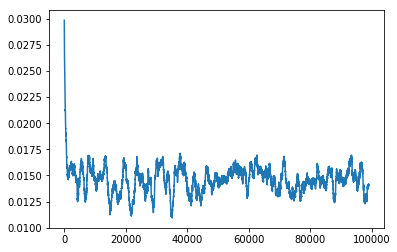

In [65]:
total_rewards = 0
deltas = []

for episode in tqdm(range(N_EPISODES),desc='EPISODES COMPLETED'):
    eps = EPSILON / (1.0 + episode * 0.01)
    if episode %10000 ==0:
        print("Episodes : ",episode,'| Avg Rewards : ',total_rewards,'| Epsilon : ',eps)
        total_rewards = 0
    curr_state = (2,0)
    grid.set_state(curr_state)
    biggest_change = 0 
    curr_action = epsilon_action(curr_state,eps=eps)
    while True:
        prev_state = curr_state
        prev_action = curr_action
        reward = grid.move(curr_action)
        total_rewards+=reward
        curr_state = grid.current_state()
        oldq = Q[prev_state][prev_action]
        curr_action = epsilon_action(curr_state,eps=eps)
        update_Q(prev_state,prev_action,reward,curr_state,curr_action)
        biggest_change = max( biggest_change, abs(oldq - Q[prev_state][prev_action]) )
        if grid.is_terminal(curr_state):
            break
    deltas.append(biggest_change)

policy = {}
values = {}
for s in grid.non_terminal_states():
    best_a = None
    best_v = float('-inf')
    for a,v in Q[s].items():
        if best_v < v:
            best_v = v
            best_a = a
    policy[s] = best_a
    values[s] = best_v

print_values(values,grid)
print_policy(policy,grid)

plt.plot(moving_average(deltas,n=1000))
plt.show()